# Simulation Model

In [74]:
# -------------------------------------------------------------------------------
# import packages
import import_ipynb
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# -------------------------------------------------------------------------------
# import scripts
from data_processing import hiring_data
import functions.algorithmic_model as am
import functions.selection_algorithm as selection

In [75]:
hiring_data['gender'].value_counts()

gender
0    2127
1    1790
Name: count, dtype: int64

## Create Model Interview Invitation

### Questions:

- lets think about if the model is trained with a fair dataset but the input is not fair since more male will apply for those positions.
- This model is always taking the whole dataset/ test set as input. No subset of the data is taken.
- I can do subsampling based on what companies would take into the interview stage, so I could do that certain parameters as qualification play a role when creating the subsamples. After that I create the other parameter which is based on literature of hiring who is more likely to get hired and have another limitation. The algorithm is of course trained on the biggest part of the dataset. Lets see how many rows that should be, maybe less than 80% to still have enough data for the subsampling process.
- Every parameter I put in the selection process is of course influenced by the distribution, so how do I deal with that to make a strong argument for my thesis, and that it is not just like a made it up. Social Sciences literature shows tendencies but not exact numbers. I put numbers into the data. How many possibilities should I show?

### Features

- How much do I care about performance? Scaling, Polynomial features, etc.

### Logistitic regression model (no fairness)

In [76]:
# data to X and y
X = hiring_data.drop(columns=['decision', 'Id', 'company'])
y = hiring_data['decision']
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test, y_pred_logistic, report, model_standard = am.logistic_regression(X,y)
y_probs = model_standard.predict_proba(X_test)[:,1]

# confusion matrix
confusion_matrix(y_test, y_pred_logistic)

array([[482,  48],
       [169,  85]])

### Logistitic regression model (with Demographic parity)

In [77]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
from sklearn.linear_model import LogisticRegression
from fairlearn.reductions import ErrorRate

# Define model
model = LogisticRegression(max_iter=4000)

# Fairness constraint: Demographic Parity
constraint = DemographicParity()

# Apply fairness-aware training using ExponentiatedGradient (a reduction method)
fair_model = ExponentiatedGradient(model, constraints=constraint)
fair_model.fit(X_train, y_train, sensitive_features=X_train['gender'])

# Get predictions from fairness-aware model
y_pred_logistic_parity = fair_model.predict(X_test)


### Logistic Regression Model (Reweighted)

In [78]:
# Get indices for male and female
male_idx = X_test['gender'] == 0  # 0 = Male
female_idx = X_test['gender'] == 1  # 1 = Female

# Compute selection rates
male_selection_rate = np.mean(y_pred_logistic[male_idx])
female_selection_rate = np.mean(y_pred_logistic[female_idx])

# Compute Disparate Impact (should ideally be close to 1)
disparate_impact = female_selection_rate / male_selection_rate if male_selection_rate > 0 else np.nan

# Compute inverse sample weights, giving more weight to underrepresented group (female)
weights = np.where(X_train['gender'] == 0, female_selection_rate / male_selection_rate * 100, 1)

In [79]:
X_train, X_test, y_train, y_test, y_pred_logistic_weighted, report2, model_reweight = am.logistic_regression(X,y, weights = weights)
y_probs2 = model_standard.predict_proba(X_test)[:,1]

# confusion matrix
confusion_matrix(y_test, y_pred_logistic_weighted)

array([[487,  43],
       [170,  84]])

### Random Forest Classifier

In [80]:
X_train, X_test, y_train, y_test, y_pred_forest, report_forest, model_forest = am.random_forest(X, y)
y_probs_forest = model_forest.predict_proba(X_test)[:, 1]

# confusion matrix
confusion_matrix(y_test, y_pred_forest)

array([[440,  90],
       [132, 122]])

### Random Forest Classifier (Reweighted)

In [81]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(sampling_strategy="auto", random_state=42)
X_train_resampled, y_train_resampled = rus.fit_resample(X_train, y_train)

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_resampled, y_train_resampled)
y_pred_forest_reweight = rf.predict(X_test)

# confusion matrix
confusion_matrix(y_test, y_pred_forest_reweight)

array([[355, 175],
       [ 80, 174]])

### Random Forest Classifier (Statistical Parity)

In [82]:
male_selection_rate = np.mean(y_pred_forest[male_idx])
female_selection_rate = np.mean(y_pred_forest[female_idx])

# Compute Statistical Parity Difference (SPD)
statistical_parity = female_selection_rate - male_selection_rate

# Compute Disparate Impact
disparate_impact = female_selection_rate / male_selection_rate if male_selection_rate > 0 else np.nan

# Compute inverse sample weights (to mitigate gender bias)
weights = np.where(X_train['gender'] == 1, male_selection_rate / female_selection_rate * 100, 1)

# Retrain with sample weights
X_train, X_test, y_train, y_test, y_pred_forest_parity, report_forest_parity, model_forest_parity = am.random_forest(X, y, weights=weights)

# confusion matrix
confusion_matrix(y_test, y_pred_forest_parity)

array([[444,  86],
       [131, 123]])

### Compare Reports

In [83]:
print(report)
print(report_forest)

              precision    recall  f1-score   support

           0       0.74      0.91      0.82       530
           1       0.64      0.33      0.44       254

    accuracy                           0.72       784
   macro avg       0.69      0.62      0.63       784
weighted avg       0.71      0.72      0.69       784

              precision    recall  f1-score   support

           0       0.77      0.83      0.80       530
           1       0.58      0.48      0.52       254

    accuracy                           0.72       784
   macro avg       0.67      0.66      0.66       784
weighted avg       0.71      0.72      0.71       784



### Add Outcome to Dataframe

In [84]:
# add to X test the values of y_pred
X_test['y_pred_logistic'] = y_pred_logistic
X_test['y_pred_logistic_weighted'] = y_pred_logistic_weighted
X_test['y_pred_logistic_parity'] = y_pred_logistic_parity
X_test['y_pred_forest'] = y_pred_forest
X_test['y_pred_forest_weighted'] = y_pred_forest_reweight
X_test['y_pred_forest_parity'] = y_pred_forest_parity

In [85]:
print(X_test.groupby('y_pred_logistic')['gender'].count())
print(X_test.groupby('y_pred_logistic_weighted')['gender'].count())
print(X_test.groupby('y_pred_logistic_parity')['gender'].count())
print(X_test.groupby('y_pred_forest')['gender'].count())
print(X_test.groupby('y_pred_forest_weighted')['gender'].count())



y_pred_logistic
0    651
1    133
Name: gender, dtype: int64
y_pred_logistic_weighted
0    657
1    127
Name: gender, dtype: int64
y_pred_logistic_parity
0    642
1    142
Name: gender, dtype: int64
y_pred_forest
0    572
1    212
Name: gender, dtype: int64
y_pred_forest_weighted
0    435
1    349
Name: gender, dtype: int64


### Look at Selection Rates of Interview

In [86]:
# Compute selection rates again
male_selection_rate_post = np.mean(y_pred_logistic_parity[male_idx])
female_selection_rate_post = np.mean(y_pred_logistic_parity[female_idx])

# Compute Disparate Impact after debiasing
disparate_impact_post = female_selection_rate_post / male_selection_rate_post if male_selection_rate_post > 0 else np.nan

# Print results before and after debiasing
print("=== Before Debiasing ===")
print(f"Male Selection Rate: {male_selection_rate:.2f}")
print(f"Female Selection Rate: {female_selection_rate:.2f}")
print(f"Disparate Impact: {disparate_impact:.2f}")

print("\n=== After Debiasing ===")
print(f"Male Selection Rate: {male_selection_rate_post:.2f}")
print(f"Female Selection Rate: {female_selection_rate_post:.2f}")
print(f"Disparate Impact: {disparate_impact_post:.2f}")

=== Before Debiasing ===
Male Selection Rate: 0.30
Female Selection Rate: 0.23
Disparate Impact: 0.77

=== After Debiasing ===
Male Selection Rate: 0.18
Female Selection Rate: 0.18
Disparate Impact: 1.04


## Hiring Result

In [87]:
# # 1. Random Subsampling (50% of test set) for Monte Carlo Simulation
# X_test = X_test.sample(frac=0.33)
# print(len(X_test))

In [88]:
# Define weights for gender and experience
gender_weights = {0: 0.3, 1: 0.7} 
X_test["grade_norm"] = X_test["ind-university_grade"] / 100  
study_weights = {0: 0.5, 1: 0.5}

X_test["weight"] = X_test.apply(
    lambda row: gender_weights[row["gender"]] * row["grade_norm"],
    axis=1
)

# Normalize weights so they sum to 1
X_test["weight"] /= X_test["weight"].sum()

# Sample using the computed weights
X_test = X_test.sample(frac=0.33, weights="weight", random_state=42)

# Drop weight column after sampling
X_test = X_test.drop(columns=["weight"])

#### Visualisation of Result Distribution of Outcome Variable

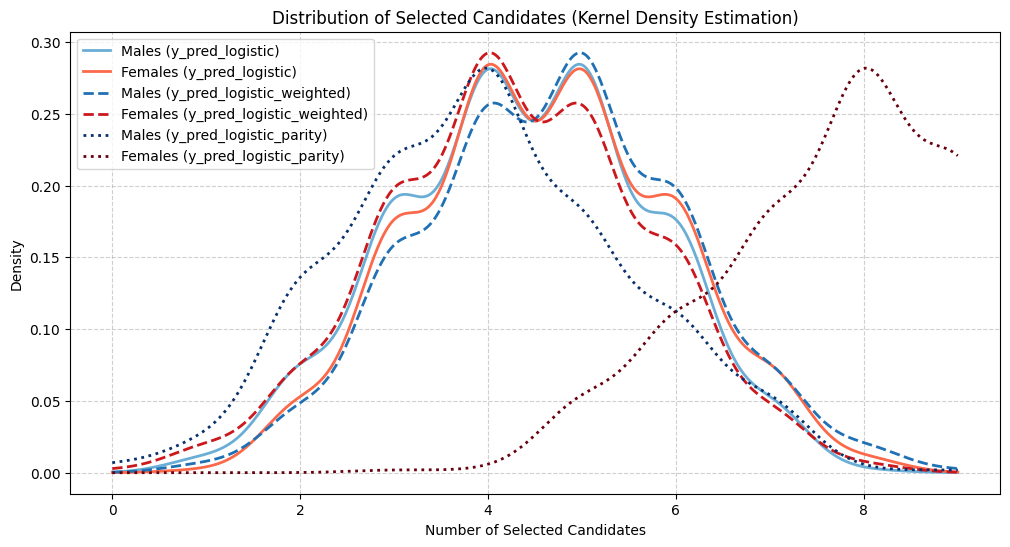

Mean and Standard Deviation for y_pred_logistic:
  Male Mean: 4.40, Male Std: 1.32
  Female Mean: 4.60, Female Std: 1.32
Mean and Standard Deviation for y_pred_logistic_weighted:
  Male Mean: 4.69, Male Std: 1.37
  Female Mean: 4.31, Female Std: 1.37
Mean and Standard Deviation for y_pred_logistic_parity:
  Male Mean: 3.99, Male Std: 1.48
  Female Mean: 8.01, Female Std: 1.48


In [89]:

preds = ['y_pred_logistic', 'y_pred_logistic_weighted', 'y_pred_logistic_parity']
selection.analyze_gender_selection(preds, X_test, selection_function = selection.biased_selection, male_selection_prob=0.5, female_selection_prob=0.5)

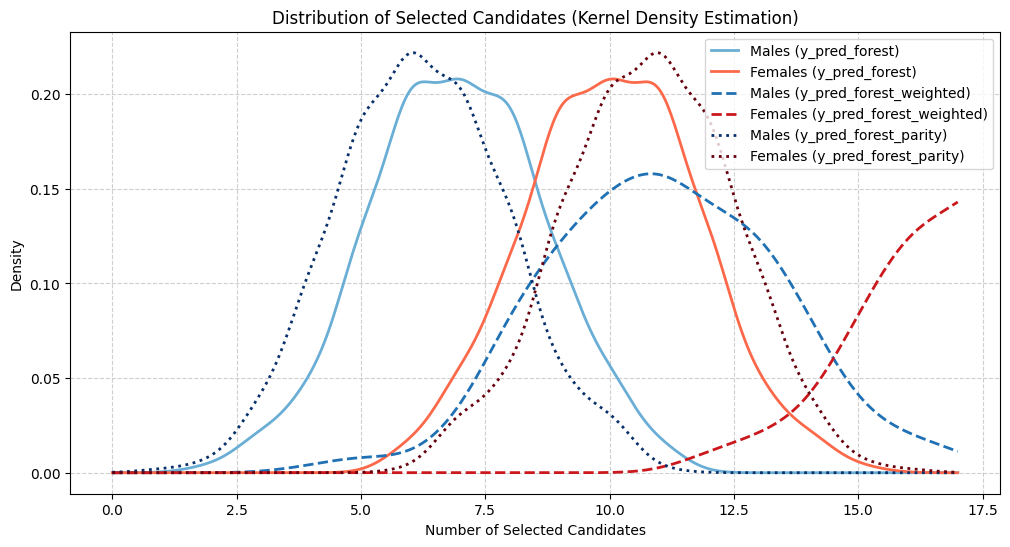

Mean and Standard Deviation for y_pred_forest:
  Male Mean: 6.93, Male Std: 1.72
  Female Mean: 10.07, Female Std: 1.72
Mean and Standard Deviation for y_pred_forest_weighted:
  Male Mean: 11.06, Male Std: 2.34
  Female Mean: 17.94, Female Std: 2.34
Mean and Standard Deviation for y_pred_forest_parity:
  Male Mean: 6.23, Male Std: 1.68
  Female Mean: 10.77, Female Std: 1.68


In [90]:
preds = ['y_pred_forest', 'y_pred_forest_weighted', 'y_pred_forest_parity']
selection.analyze_gender_selection(preds, X_test, selection_function = selection.biased_selection, male_selection_prob=0.5, female_selection_prob=0.5)
